# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

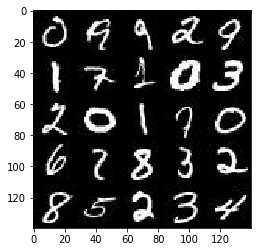

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

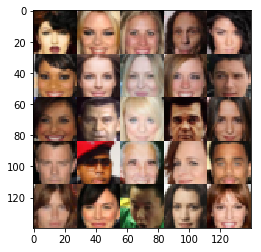

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input');
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [19]:
def leak_relu(x, multiplier=0.1):
    '''
    x: Tensor
    multiplier: leak multiplier 
    
    Returns max tensor on input tensor. 
    '''
    return tf.maximum(x, x * multiplier)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Image size is 28x28x(1 - MNIST, 3 - celeb)
        layer = tf.layers.conv2d(images, 
                                 64, 
                                 3, 
                                 strides=2, 
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer = leak_relu(layer)
        layer = tf.layers.dropout(layer, rate=0.9)
        
        
        # Image 7x7x128 
        layer = tf.layers.conv2d(layer, 
                                 128, 
                                 3, 
                                 strides=2, 
                                 padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = leak_relu(layer)
        layer = tf.layers.dropout(layer, rate=0.9)
        

        # Image 4x4x25
        layer = tf.layers.conv2d(layer, 
                                 256, 
                                 3, 
                                 strides=2,
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = leak_relu(layer)
        layer = tf.layers.dropout(layer, rate=0.9)
        

        flat = tf.reshape(layer, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train = True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not is_train):
        
        # Image 7x7x1024
        layer = tf.layers.dense(z, 7*7*1024)
        layer = tf.reshape(layer, (-1, 7, 7, 1024))
        layer = tf.layers.batch_normalization(layer, training = is_train)
        layer = tf.nn.relu(layer)
        
        # Image 14x14x512
        layer = tf.layers.conv2d_transpose(layer, 512, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training = is_train)
        relu = tf.nn.relu(layer)
         
        # Image 28x28x256
        layer = tf.layers.conv2d_transpose(layer, 256, 3, strides=2, padding='same')
        layer = tf.layers.batch_normalization(layer, training = is_train)
        layer = tf.nn.relu(layer)

        layer = tf.layers.conv2d_transpose(layer, out_channel_dim, 3, strides=2, padding='same')
        layer = tf.image.resize_images(layer, size=(28, 28)) 
        
        output = tf.nn.tanh(layer, name='generator_main')
        
    return output
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim, is_train = True)
    
    discriminator_real_model, discriminator_real_logits = discriminator(input_real, reuse=False)
    discriminator_fake_model, discriminator_fake_logits = discriminator(generator_model, reuse=True)
    
    smooth = 0.1
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits,
                                                                         labels=tf.ones_like(discriminator_real_model) * (1 - smooth)))
    
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, 
                                                                         labels=tf.zeros_like(discriminator_fake_model)))
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, 
                                                                    labels = tf.ones_like(discriminator_fake_model)))
    
    return discriminator_loss, generator_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [36]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    training_vars = tf.trainable_variables()
    discriminator_vars = [var for var in training_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in training_vars if var.name.startswith('generator')]
    
    discriminator_ops = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(d_loss, 
                                                                                                      var_list = discriminator_vars)
    
    
    generator_ops = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(g_loss, 
                                                                                                  var_list = generator_vars)
   
    return discriminator_ops, generator_ops



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [38]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    d_ops, g_ops = model_opt(d_loss, g_loss, lr, beta1)
    
    batch = 0;
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch += 1

                # since discriminator expects values from -1 to 1  
                batch_images = 2 * batch_images
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                sess.run(g_ops, feed_dict = {
                    lr :learning_rate,
                    z_input : batch_z,
                })
                
                sess.run(d_ops, feed_dict = {
                    lr : learning_rate,
                    real_input : batch_images, 
                    z_input : batch_z
                })
                
                
                if batch % 10 == 0:
                    # run losses. 
                    train_loss_d = sess.run(d_loss, feed_dict = { real_input : batch_images, z_input : batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict =  { z_input : batch_z})
                    print("Epoch {}/{}... Step {}...".format(epoch_i+1, epochs, batch),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    
                if batch % 100 == 0:
                    print("Sample Outputs....")
                    show_generator_output(sess, 10, z_input, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10... Discriminator Loss: 0.3434... Generator Loss: 6.4929
Epoch 1/2... Step 20... Discriminator Loss: 0.3943... Generator Loss: 16.8060
Epoch 1/2... Step 30... Discriminator Loss: 0.3400... Generator Loss: 6.7432
Epoch 1/2... Step 40... Discriminator Loss: 0.8246... Generator Loss: 5.2184
Epoch 1/2... Step 50... Discriminator Loss: 0.3646... Generator Loss: 4.9056
Epoch 1/2... Step 60... Discriminator Loss: 0.8921... Generator Loss: 1.3694
Epoch 1/2... Step 70... Discriminator Loss: 1.0743... Generator Loss: 0.8435
Epoch 1/2... Step 80... Discriminator Loss: 1.1893... Generator Loss: 0.7205
Epoch 1/2... Step 90... Discriminator Loss: 1.1532... Generator Loss: 2.0178
Epoch 1/2... Step 100... Discriminator Loss: 1.1212... Generator Loss: 1.3582
Sample Outputs....


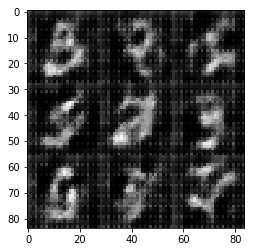

Epoch 1/2... Step 110... Discriminator Loss: 1.3023... Generator Loss: 2.0662
Epoch 1/2... Step 120... Discriminator Loss: 1.2316... Generator Loss: 1.6547
Epoch 1/2... Step 130... Discriminator Loss: 1.2943... Generator Loss: 1.7364
Epoch 1/2... Step 140... Discriminator Loss: 1.1404... Generator Loss: 1.5332
Epoch 1/2... Step 150... Discriminator Loss: 1.2026... Generator Loss: 0.7320
Epoch 1/2... Step 160... Discriminator Loss: 1.1521... Generator Loss: 0.8001
Epoch 1/2... Step 170... Discriminator Loss: 1.2880... Generator Loss: 0.5702
Epoch 1/2... Step 180... Discriminator Loss: 1.1048... Generator Loss: 0.9182
Epoch 1/2... Step 190... Discriminator Loss: 1.1194... Generator Loss: 1.3325
Epoch 1/2... Step 200... Discriminator Loss: 1.2403... Generator Loss: 1.9946
Sample Outputs....


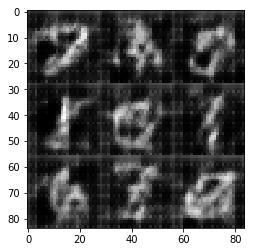

Epoch 1/2... Step 210... Discriminator Loss: 1.2971... Generator Loss: 1.9635
Epoch 1/2... Step 220... Discriminator Loss: 1.3302... Generator Loss: 1.9287
Epoch 1/2... Step 230... Discriminator Loss: 1.2597... Generator Loss: 1.6436
Epoch 1/2... Step 240... Discriminator Loss: 1.2093... Generator Loss: 0.6844
Epoch 1/2... Step 250... Discriminator Loss: 1.2063... Generator Loss: 0.7460
Epoch 1/2... Step 260... Discriminator Loss: 1.1211... Generator Loss: 0.9433
Epoch 1/2... Step 270... Discriminator Loss: 1.4173... Generator Loss: 0.4583
Epoch 1/2... Step 280... Discriminator Loss: 1.2218... Generator Loss: 0.7616
Epoch 1/2... Step 290... Discriminator Loss: 1.2295... Generator Loss: 0.6334
Epoch 1/2... Step 300... Discriminator Loss: 1.1919... Generator Loss: 0.7448
Sample Outputs....


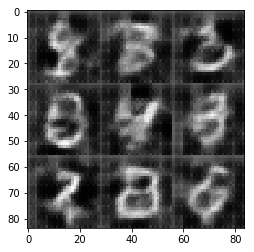

Epoch 1/2... Step 310... Discriminator Loss: 1.1919... Generator Loss: 0.7219
Epoch 1/2... Step 320... Discriminator Loss: 1.1326... Generator Loss: 0.7986
Epoch 1/2... Step 330... Discriminator Loss: 1.1654... Generator Loss: 0.8237
Epoch 1/2... Step 340... Discriminator Loss: 1.3302... Generator Loss: 0.5596
Epoch 1/2... Step 350... Discriminator Loss: 1.1246... Generator Loss: 0.8961
Epoch 1/2... Step 360... Discriminator Loss: 1.3633... Generator Loss: 1.8532
Epoch 1/2... Step 370... Discriminator Loss: 1.2461... Generator Loss: 1.3783
Epoch 1/2... Step 380... Discriminator Loss: 1.2791... Generator Loss: 1.7496
Epoch 1/2... Step 390... Discriminator Loss: 1.2219... Generator Loss: 1.4571
Epoch 1/2... Step 400... Discriminator Loss: 1.1806... Generator Loss: 1.3492
Sample Outputs....


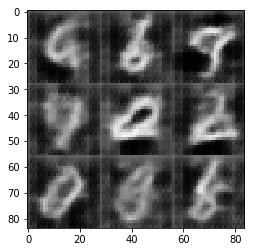

Epoch 1/2... Step 410... Discriminator Loss: 1.1474... Generator Loss: 1.5426
Epoch 1/2... Step 420... Discriminator Loss: 1.1407... Generator Loss: 1.1754
Epoch 1/2... Step 430... Discriminator Loss: 1.0789... Generator Loss: 0.9269
Epoch 1/2... Step 440... Discriminator Loss: 1.3356... Generator Loss: 0.5854
Epoch 1/2... Step 450... Discriminator Loss: 1.1667... Generator Loss: 0.8487
Epoch 1/2... Step 460... Discriminator Loss: 1.2744... Generator Loss: 0.6491
Epoch 1/2... Step 470... Discriminator Loss: 1.1029... Generator Loss: 0.9740
Epoch 1/2... Step 480... Discriminator Loss: 1.2013... Generator Loss: 1.4678
Epoch 1/2... Step 490... Discriminator Loss: 1.2437... Generator Loss: 0.5964
Epoch 1/2... Step 500... Discriminator Loss: 1.1529... Generator Loss: 0.8518
Sample Outputs....


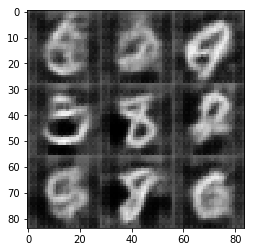

Epoch 1/2... Step 510... Discriminator Loss: 1.1579... Generator Loss: 0.7589
Epoch 1/2... Step 520... Discriminator Loss: 1.1517... Generator Loss: 0.7466
Epoch 1/2... Step 530... Discriminator Loss: 1.2322... Generator Loss: 0.6408
Epoch 1/2... Step 540... Discriminator Loss: 1.1502... Generator Loss: 1.3673
Epoch 1/2... Step 550... Discriminator Loss: 1.8314... Generator Loss: 2.4115
Epoch 1/2... Step 560... Discriminator Loss: 1.1775... Generator Loss: 1.0520
Epoch 1/2... Step 570... Discriminator Loss: 1.1836... Generator Loss: 0.7154
Epoch 1/2... Step 580... Discriminator Loss: 1.2285... Generator Loss: 0.6425
Epoch 1/2... Step 590... Discriminator Loss: 1.1557... Generator Loss: 0.7726
Epoch 1/2... Step 600... Discriminator Loss: 1.0921... Generator Loss: 0.8748
Sample Outputs....


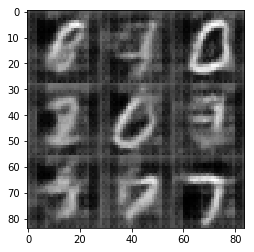

Epoch 1/2... Step 610... Discriminator Loss: 1.1783... Generator Loss: 1.0855
Epoch 1/2... Step 620... Discriminator Loss: 1.0522... Generator Loss: 1.0977
Epoch 1/2... Step 630... Discriminator Loss: 1.3575... Generator Loss: 2.0038
Epoch 1/2... Step 640... Discriminator Loss: 1.1584... Generator Loss: 1.3150
Epoch 1/2... Step 650... Discriminator Loss: 1.0624... Generator Loss: 0.9474
Epoch 1/2... Step 660... Discriminator Loss: 1.0532... Generator Loss: 1.3459
Epoch 1/2... Step 670... Discriminator Loss: 1.2699... Generator Loss: 1.6925
Epoch 1/2... Step 680... Discriminator Loss: 1.1401... Generator Loss: 0.9937
Epoch 1/2... Step 690... Discriminator Loss: 1.0598... Generator Loss: 1.1008
Epoch 1/2... Step 700... Discriminator Loss: 1.1471... Generator Loss: 0.8013
Sample Outputs....


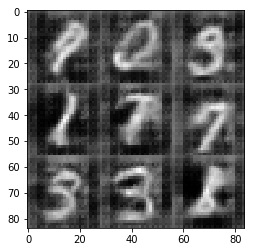

Epoch 1/2... Step 710... Discriminator Loss: 1.0822... Generator Loss: 1.1034
Epoch 1/2... Step 720... Discriminator Loss: 1.0893... Generator Loss: 0.8552
Epoch 1/2... Step 730... Discriminator Loss: 1.1947... Generator Loss: 1.0292
Epoch 1/2... Step 740... Discriminator Loss: 1.1400... Generator Loss: 1.2378
Epoch 1/2... Step 750... Discriminator Loss: 1.0396... Generator Loss: 1.1196
Epoch 1/2... Step 760... Discriminator Loss: 1.1938... Generator Loss: 0.8200
Epoch 1/2... Step 770... Discriminator Loss: 1.0313... Generator Loss: 1.3009
Epoch 1/2... Step 780... Discriminator Loss: 1.0818... Generator Loss: 1.1112
Epoch 1/2... Step 790... Discriminator Loss: 1.0488... Generator Loss: 1.4657
Epoch 1/2... Step 800... Discriminator Loss: 1.1006... Generator Loss: 1.0576
Sample Outputs....


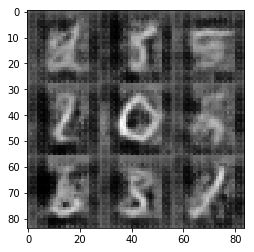

Epoch 1/2... Step 810... Discriminator Loss: 1.0875... Generator Loss: 1.0702
Epoch 1/2... Step 820... Discriminator Loss: 1.3367... Generator Loss: 1.9245
Epoch 1/2... Step 830... Discriminator Loss: 1.0651... Generator Loss: 1.1265
Epoch 1/2... Step 840... Discriminator Loss: 1.1945... Generator Loss: 0.7302
Epoch 1/2... Step 850... Discriminator Loss: 1.2436... Generator Loss: 0.6255
Epoch 1/2... Step 860... Discriminator Loss: 1.1221... Generator Loss: 0.7782
Epoch 1/2... Step 870... Discriminator Loss: 1.1312... Generator Loss: 1.0949
Epoch 1/2... Step 880... Discriminator Loss: 1.2043... Generator Loss: 0.6508
Epoch 1/2... Step 890... Discriminator Loss: 1.0936... Generator Loss: 1.3106
Epoch 1/2... Step 900... Discriminator Loss: 1.2093... Generator Loss: 1.3481
Sample Outputs....


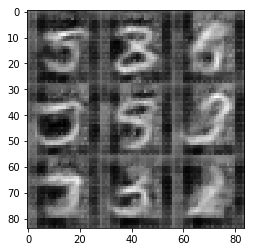

Epoch 1/2... Step 910... Discriminator Loss: 1.1168... Generator Loss: 0.9698
Epoch 1/2... Step 920... Discriminator Loss: 1.0548... Generator Loss: 0.9282
Epoch 1/2... Step 930... Discriminator Loss: 1.0414... Generator Loss: 0.9722
Epoch 2/2... Step 940... Discriminator Loss: 1.1822... Generator Loss: 0.7119
Epoch 2/2... Step 950... Discriminator Loss: 1.1972... Generator Loss: 1.6395
Epoch 2/2... Step 960... Discriminator Loss: 1.1808... Generator Loss: 1.5186
Epoch 2/2... Step 970... Discriminator Loss: 1.1366... Generator Loss: 0.8632
Epoch 2/2... Step 980... Discriminator Loss: 1.3102... Generator Loss: 0.5782
Epoch 2/2... Step 990... Discriminator Loss: 1.0734... Generator Loss: 1.2602
Epoch 2/2... Step 1000... Discriminator Loss: 1.4019... Generator Loss: 2.0384
Sample Outputs....


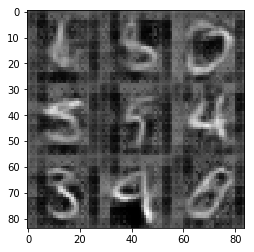

Epoch 2/2... Step 1010... Discriminator Loss: 1.0036... Generator Loss: 1.3749
Epoch 2/2... Step 1020... Discriminator Loss: 1.5811... Generator Loss: 2.3687
Epoch 2/2... Step 1030... Discriminator Loss: 1.1615... Generator Loss: 0.9218
Epoch 2/2... Step 1040... Discriminator Loss: 1.1573... Generator Loss: 1.4919
Epoch 2/2... Step 1050... Discriminator Loss: 1.1076... Generator Loss: 0.8422
Epoch 2/2... Step 1060... Discriminator Loss: 1.1423... Generator Loss: 1.4892
Epoch 2/2... Step 1070... Discriminator Loss: 1.1141... Generator Loss: 1.0631
Epoch 2/2... Step 1080... Discriminator Loss: 1.1091... Generator Loss: 0.8224
Epoch 2/2... Step 1090... Discriminator Loss: 1.1348... Generator Loss: 0.7912
Epoch 2/2... Step 1100... Discriminator Loss: 1.2156... Generator Loss: 1.6610
Sample Outputs....


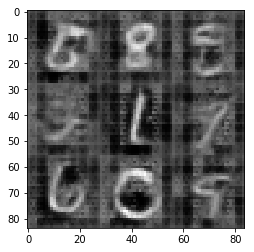

Epoch 2/2... Step 1110... Discriminator Loss: 1.1276... Generator Loss: 1.6891
Epoch 2/2... Step 1120... Discriminator Loss: 1.1138... Generator Loss: 1.2312
Epoch 2/2... Step 1130... Discriminator Loss: 1.0410... Generator Loss: 1.3690
Epoch 2/2... Step 1140... Discriminator Loss: 1.1474... Generator Loss: 0.7355
Epoch 2/2... Step 1150... Discriminator Loss: 1.1066... Generator Loss: 0.8963
Epoch 2/2... Step 1160... Discriminator Loss: 1.1092... Generator Loss: 0.8673
Epoch 2/2... Step 1170... Discriminator Loss: 1.2677... Generator Loss: 2.0508
Epoch 2/2... Step 1180... Discriminator Loss: 1.0558... Generator Loss: 1.1126
Epoch 2/2... Step 1190... Discriminator Loss: 1.3196... Generator Loss: 0.5320
Epoch 2/2... Step 1200... Discriminator Loss: 1.0575... Generator Loss: 1.0961
Sample Outputs....


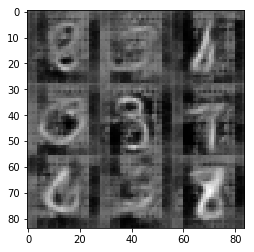

Epoch 2/2... Step 1210... Discriminator Loss: 0.9674... Generator Loss: 0.9264
Epoch 2/2... Step 1220... Discriminator Loss: 1.9566... Generator Loss: 0.2467
Epoch 2/2... Step 1230... Discriminator Loss: 1.1825... Generator Loss: 0.8695
Epoch 2/2... Step 1240... Discriminator Loss: 1.1047... Generator Loss: 0.9202
Epoch 2/2... Step 1250... Discriminator Loss: 1.0626... Generator Loss: 1.2430
Epoch 2/2... Step 1260... Discriminator Loss: 1.1156... Generator Loss: 0.9032
Epoch 2/2... Step 1270... Discriminator Loss: 1.1860... Generator Loss: 1.5723
Epoch 2/2... Step 1280... Discriminator Loss: 1.0278... Generator Loss: 0.8409
Epoch 2/2... Step 1290... Discriminator Loss: 0.8816... Generator Loss: 1.3836
Epoch 2/2... Step 1300... Discriminator Loss: 1.4966... Generator Loss: 2.2764
Sample Outputs....


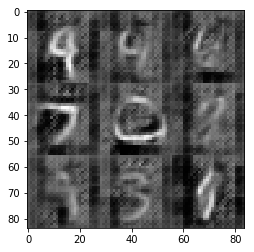

Epoch 2/2... Step 1310... Discriminator Loss: 1.0999... Generator Loss: 1.1424
Epoch 2/2... Step 1320... Discriminator Loss: 1.0688... Generator Loss: 0.8144
Epoch 2/2... Step 1330... Discriminator Loss: 1.4706... Generator Loss: 0.4422
Epoch 2/2... Step 1340... Discriminator Loss: 1.0729... Generator Loss: 0.9268
Epoch 2/2... Step 1350... Discriminator Loss: 0.9892... Generator Loss: 1.3685
Epoch 2/2... Step 1360... Discriminator Loss: 1.0069... Generator Loss: 1.5415
Epoch 2/2... Step 1370... Discriminator Loss: 1.0344... Generator Loss: 1.9435
Epoch 2/2... Step 1380... Discriminator Loss: 1.0818... Generator Loss: 1.2121
Epoch 2/2... Step 1390... Discriminator Loss: 1.1280... Generator Loss: 1.4029
Epoch 2/2... Step 1400... Discriminator Loss: 1.0446... Generator Loss: 0.9450
Sample Outputs....


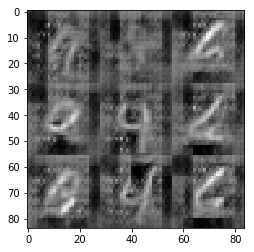

Epoch 2/2... Step 1410... Discriminator Loss: 0.9684... Generator Loss: 1.3778
Epoch 2/2... Step 1420... Discriminator Loss: 1.1623... Generator Loss: 2.0253
Epoch 2/2... Step 1430... Discriminator Loss: 1.6147... Generator Loss: 2.5541
Epoch 2/2... Step 1440... Discriminator Loss: 1.0789... Generator Loss: 1.3191
Epoch 2/2... Step 1450... Discriminator Loss: 0.9524... Generator Loss: 1.4181
Epoch 2/2... Step 1460... Discriminator Loss: 1.7122... Generator Loss: 0.3207
Epoch 2/2... Step 1470... Discriminator Loss: 0.9493... Generator Loss: 1.3096
Epoch 2/2... Step 1480... Discriminator Loss: 1.2165... Generator Loss: 1.9575
Epoch 2/2... Step 1490... Discriminator Loss: 1.1117... Generator Loss: 0.7443
Epoch 2/2... Step 1500... Discriminator Loss: 1.1391... Generator Loss: 0.7077
Sample Outputs....


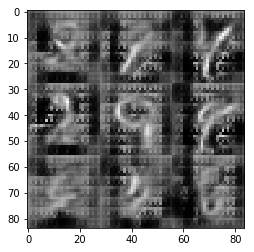

Epoch 2/2... Step 1510... Discriminator Loss: 1.1935... Generator Loss: 0.6840
Epoch 2/2... Step 1520... Discriminator Loss: 1.1248... Generator Loss: 0.7115
Epoch 2/2... Step 1530... Discriminator Loss: 0.9459... Generator Loss: 1.4090
Epoch 2/2... Step 1540... Discriminator Loss: 1.7291... Generator Loss: 3.0697
Epoch 2/2... Step 1550... Discriminator Loss: 0.8660... Generator Loss: 1.2456
Epoch 2/2... Step 1560... Discriminator Loss: 0.8602... Generator Loss: 1.6364
Epoch 2/2... Step 1570... Discriminator Loss: 1.0646... Generator Loss: 1.5382
Epoch 2/2... Step 1580... Discriminator Loss: 0.8685... Generator Loss: 1.5083
Epoch 2/2... Step 1590... Discriminator Loss: 1.1425... Generator Loss: 0.7900
Epoch 2/2... Step 1600... Discriminator Loss: 0.9088... Generator Loss: 1.0354
Sample Outputs....


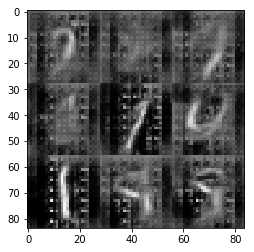

Epoch 2/2... Step 1610... Discriminator Loss: 0.9596... Generator Loss: 1.0544
Epoch 2/2... Step 1620... Discriminator Loss: 0.9805... Generator Loss: 1.4172
Epoch 2/2... Step 1630... Discriminator Loss: 1.2092... Generator Loss: 1.9439
Epoch 2/2... Step 1640... Discriminator Loss: 0.9617... Generator Loss: 1.8800
Epoch 2/2... Step 1650... Discriminator Loss: 1.7822... Generator Loss: 2.9959
Epoch 2/2... Step 1660... Discriminator Loss: 1.0987... Generator Loss: 1.0867
Epoch 2/2... Step 1670... Discriminator Loss: 0.9710... Generator Loss: 1.5121
Epoch 2/2... Step 1680... Discriminator Loss: 1.1099... Generator Loss: 1.9314
Epoch 2/2... Step 1690... Discriminator Loss: 1.0352... Generator Loss: 1.9002
Epoch 2/2... Step 1700... Discriminator Loss: 1.0996... Generator Loss: 1.6718
Sample Outputs....


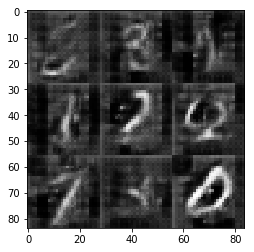

Epoch 2/2... Step 1710... Discriminator Loss: 0.9562... Generator Loss: 1.0708
Epoch 2/2... Step 1720... Discriminator Loss: 0.9485... Generator Loss: 1.1100
Epoch 2/2... Step 1730... Discriminator Loss: 1.1088... Generator Loss: 0.7628
Epoch 2/2... Step 1740... Discriminator Loss: 1.0578... Generator Loss: 1.3610
Epoch 2/2... Step 1750... Discriminator Loss: 0.8886... Generator Loss: 1.4534
Epoch 2/2... Step 1760... Discriminator Loss: 1.0286... Generator Loss: 1.2209
Epoch 2/2... Step 1770... Discriminator Loss: 0.9673... Generator Loss: 1.0321
Epoch 2/2... Step 1780... Discriminator Loss: 0.9819... Generator Loss: 1.4878
Epoch 2/2... Step 1790... Discriminator Loss: 1.0103... Generator Loss: 1.4086
Epoch 2/2... Step 1800... Discriminator Loss: 1.1117... Generator Loss: 2.0709
Sample Outputs....


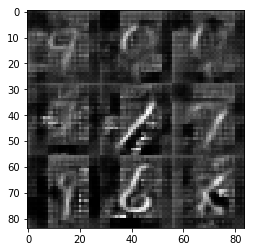

Epoch 2/2... Step 1810... Discriminator Loss: 0.8997... Generator Loss: 1.2329
Epoch 2/2... Step 1820... Discriminator Loss: 0.9720... Generator Loss: 1.0618
Epoch 2/2... Step 1830... Discriminator Loss: 0.9139... Generator Loss: 1.0410
Epoch 2/2... Step 1840... Discriminator Loss: 0.9963... Generator Loss: 0.9893
Epoch 2/2... Step 1850... Discriminator Loss: 0.9937... Generator Loss: 1.8976
Epoch 2/2... Step 1860... Discriminator Loss: 0.9019... Generator Loss: 2.4765
Epoch 2/2... Step 1870... Discriminator Loss: 1.0795... Generator Loss: 1.0881


In [40]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3
tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10... Discriminator Loss: 0.3883... Generator Loss: 7.7577
Epoch 1/1... Step 20... Discriminator Loss: 0.5514... Generator Loss: 11.3652
Epoch 1/1... Step 30... Discriminator Loss: 5.4107... Generator Loss: 17.7497
Epoch 1/1... Step 40... Discriminator Loss: 0.7845... Generator Loss: 3.8686
Epoch 1/1... Step 50... Discriminator Loss: 1.5573... Generator Loss: 6.3579
Epoch 1/1... Step 60... Discriminator Loss: 0.4454... Generator Loss: 3.0169
Epoch 1/1... Step 70... Discriminator Loss: 0.4458... Generator Loss: 2.9198
Epoch 1/1... Step 80... Discriminator Loss: 0.3761... Generator Loss: 4.2442
Epoch 1/1... Step 90... Discriminator Loss: 0.6615... Generator Loss: 2.6788
Epoch 1/1... Step 100... Discriminator Loss: 0.3978... Generator Loss: 3.9580
Sample Outputs....


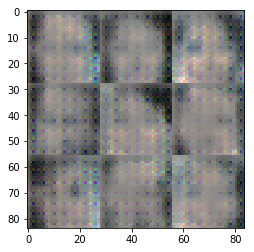

Epoch 1/1... Step 110... Discriminator Loss: 0.6327... Generator Loss: 1.6125
Epoch 1/1... Step 120... Discriminator Loss: 1.2203... Generator Loss: 2.1519
Epoch 1/1... Step 130... Discriminator Loss: 1.2918... Generator Loss: 1.1062
Epoch 1/1... Step 140... Discriminator Loss: 1.0405... Generator Loss: 1.2684
Epoch 1/1... Step 150... Discriminator Loss: 0.6857... Generator Loss: 1.4037
Epoch 1/1... Step 160... Discriminator Loss: 0.8764... Generator Loss: 1.0007
Epoch 1/1... Step 170... Discriminator Loss: 1.1216... Generator Loss: 1.1688
Epoch 1/1... Step 180... Discriminator Loss: 1.0868... Generator Loss: 1.3033
Epoch 1/1... Step 190... Discriminator Loss: 0.9581... Generator Loss: 1.5937
Epoch 1/1... Step 200... Discriminator Loss: 0.9945... Generator Loss: 1.0584
Sample Outputs....


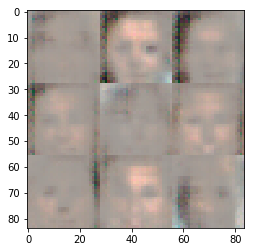

Epoch 1/1... Step 210... Discriminator Loss: 1.2864... Generator Loss: 1.7651
Epoch 1/1... Step 220... Discriminator Loss: 1.1079... Generator Loss: 1.1684
Epoch 1/1... Step 230... Discriminator Loss: 1.1145... Generator Loss: 0.9307
Epoch 1/1... Step 240... Discriminator Loss: 1.0199... Generator Loss: 1.6236
Epoch 1/1... Step 250... Discriminator Loss: 1.3018... Generator Loss: 0.8173
Epoch 1/1... Step 260... Discriminator Loss: 1.1901... Generator Loss: 0.9814
Epoch 1/1... Step 270... Discriminator Loss: 1.2886... Generator Loss: 0.9180
Epoch 1/1... Step 280... Discriminator Loss: 1.1210... Generator Loss: 1.2230
Epoch 1/1... Step 290... Discriminator Loss: 1.2658... Generator Loss: 1.4642
Epoch 1/1... Step 300... Discriminator Loss: 1.1710... Generator Loss: 0.6957
Sample Outputs....


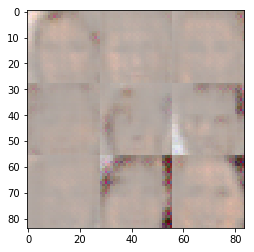

Epoch 1/1... Step 310... Discriminator Loss: 1.2207... Generator Loss: 1.0580
Epoch 1/1... Step 320... Discriminator Loss: 1.2410... Generator Loss: 0.6781
Epoch 1/1... Step 330... Discriminator Loss: 1.2603... Generator Loss: 0.7688
Epoch 1/1... Step 340... Discriminator Loss: 1.2916... Generator Loss: 1.3232
Epoch 1/1... Step 350... Discriminator Loss: 1.3186... Generator Loss: 1.4030
Epoch 1/1... Step 360... Discriminator Loss: 1.1727... Generator Loss: 1.0019
Epoch 1/1... Step 370... Discriminator Loss: 1.1227... Generator Loss: 1.0581
Epoch 1/1... Step 380... Discriminator Loss: 1.1888... Generator Loss: 0.9462
Epoch 1/1... Step 390... Discriminator Loss: 1.2420... Generator Loss: 1.0161
Epoch 1/1... Step 400... Discriminator Loss: 1.3326... Generator Loss: 0.8557
Sample Outputs....


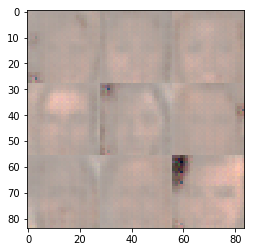

Epoch 1/1... Step 410... Discriminator Loss: 1.3184... Generator Loss: 0.8865
Epoch 1/1... Step 420... Discriminator Loss: 1.3133... Generator Loss: 0.9637
Epoch 1/1... Step 430... Discriminator Loss: 1.3590... Generator Loss: 0.8255
Epoch 1/1... Step 440... Discriminator Loss: 1.2887... Generator Loss: 0.7853
Epoch 1/1... Step 450... Discriminator Loss: 1.0870... Generator Loss: 1.0476
Epoch 1/1... Step 460... Discriminator Loss: 1.2325... Generator Loss: 0.9033
Epoch 1/1... Step 470... Discriminator Loss: 1.2501... Generator Loss: 0.8334
Epoch 1/1... Step 480... Discriminator Loss: 1.2590... Generator Loss: 0.9744
Epoch 1/1... Step 490... Discriminator Loss: 1.2935... Generator Loss: 0.6874
Epoch 1/1... Step 500... Discriminator Loss: 1.2577... Generator Loss: 0.8421
Sample Outputs....


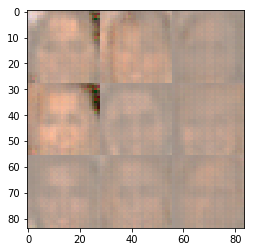

Epoch 1/1... Step 510... Discriminator Loss: 1.3116... Generator Loss: 0.8858
Epoch 1/1... Step 520... Discriminator Loss: 1.3045... Generator Loss: 0.8649
Epoch 1/1... Step 530... Discriminator Loss: 1.2743... Generator Loss: 0.6632
Epoch 1/1... Step 540... Discriminator Loss: 1.4013... Generator Loss: 1.5462
Epoch 1/1... Step 550... Discriminator Loss: 1.3063... Generator Loss: 1.4104
Epoch 1/1... Step 560... Discriminator Loss: 1.3073... Generator Loss: 1.1226
Epoch 1/1... Step 570... Discriminator Loss: 1.3161... Generator Loss: 0.8032
Epoch 1/1... Step 580... Discriminator Loss: 1.4461... Generator Loss: 0.4462
Epoch 1/1... Step 590... Discriminator Loss: 1.3165... Generator Loss: 0.9711
Epoch 1/1... Step 600... Discriminator Loss: 1.2731... Generator Loss: 0.8331
Sample Outputs....


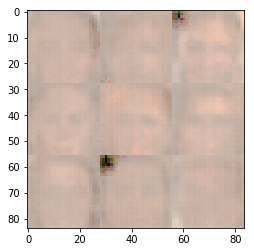

Epoch 1/1... Step 610... Discriminator Loss: 1.3286... Generator Loss: 0.9892
Epoch 1/1... Step 620... Discriminator Loss: 1.3261... Generator Loss: 1.5071
Epoch 1/1... Step 630... Discriminator Loss: 1.1579... Generator Loss: 1.0145
Epoch 1/1... Step 640... Discriminator Loss: 1.3062... Generator Loss: 1.0390
Epoch 1/1... Step 650... Discriminator Loss: 1.2638... Generator Loss: 0.9445
Epoch 1/1... Step 660... Discriminator Loss: 1.1728... Generator Loss: 1.0023
Epoch 1/1... Step 670... Discriminator Loss: 1.2419... Generator Loss: 0.9448
Epoch 1/1... Step 680... Discriminator Loss: 1.2763... Generator Loss: 0.5944
Epoch 1/1... Step 690... Discriminator Loss: 1.1424... Generator Loss: 0.9296
Epoch 1/1... Step 700... Discriminator Loss: 1.4843... Generator Loss: 2.2480
Sample Outputs....


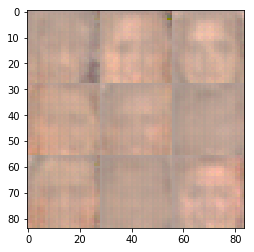

Epoch 1/1... Step 710... Discriminator Loss: 1.3454... Generator Loss: 0.6704
Epoch 1/1... Step 720... Discriminator Loss: 1.1755... Generator Loss: 1.1622
Epoch 1/1... Step 730... Discriminator Loss: 1.3302... Generator Loss: 0.7925
Epoch 1/1... Step 740... Discriminator Loss: 1.1720... Generator Loss: 0.8218
Epoch 1/1... Step 750... Discriminator Loss: 1.2619... Generator Loss: 1.5986
Epoch 1/1... Step 760... Discriminator Loss: 1.1359... Generator Loss: 0.8647
Epoch 1/1... Step 770... Discriminator Loss: 1.4483... Generator Loss: 1.7242
Epoch 1/1... Step 780... Discriminator Loss: 1.2888... Generator Loss: 0.8318
Epoch 1/1... Step 790... Discriminator Loss: 1.1951... Generator Loss: 0.7392
Epoch 1/1... Step 800... Discriminator Loss: 1.3013... Generator Loss: 0.8086
Sample Outputs....


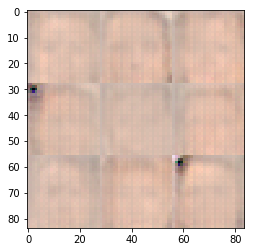

Epoch 1/1... Step 810... Discriminator Loss: 1.1071... Generator Loss: 1.0212
Epoch 1/1... Step 820... Discriminator Loss: 1.2192... Generator Loss: 1.0369
Epoch 1/1... Step 830... Discriminator Loss: 1.3086... Generator Loss: 0.8871
Epoch 1/1... Step 840... Discriminator Loss: 1.3273... Generator Loss: 0.9679
Epoch 1/1... Step 850... Discriminator Loss: 1.2144... Generator Loss: 1.0064
Epoch 1/1... Step 860... Discriminator Loss: 0.9562... Generator Loss: 1.1058
Epoch 1/1... Step 870... Discriminator Loss: 1.2023... Generator Loss: 1.0877
Epoch 1/1... Step 880... Discriminator Loss: 1.2179... Generator Loss: 0.8900
Epoch 1/1... Step 890... Discriminator Loss: 1.2131... Generator Loss: 0.8883
Epoch 1/1... Step 900... Discriminator Loss: 1.1075... Generator Loss: 1.2061
Sample Outputs....


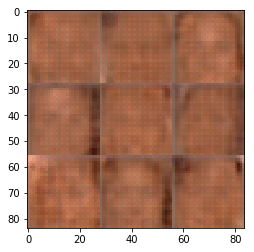

Epoch 1/1... Step 910... Discriminator Loss: 1.2487... Generator Loss: 0.7941
Epoch 1/1... Step 920... Discriminator Loss: 1.2571... Generator Loss: 1.2604
Epoch 1/1... Step 930... Discriminator Loss: 1.2873... Generator Loss: 0.8260
Epoch 1/1... Step 940... Discriminator Loss: 1.2171... Generator Loss: 1.0705
Epoch 1/1... Step 950... Discriminator Loss: 1.1676... Generator Loss: 0.8456
Epoch 1/1... Step 960... Discriminator Loss: 0.7337... Generator Loss: 1.2665
Epoch 1/1... Step 970... Discriminator Loss: 1.2588... Generator Loss: 2.2381
Epoch 1/1... Step 980... Discriminator Loss: 1.1868... Generator Loss: 1.0716
Epoch 1/1... Step 990... Discriminator Loss: 1.2551... Generator Loss: 0.9684
Epoch 1/1... Step 1000... Discriminator Loss: 1.2094... Generator Loss: 1.2737
Sample Outputs....


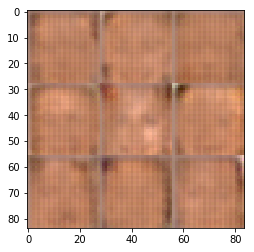

Epoch 1/1... Step 1010... Discriminator Loss: 1.1600... Generator Loss: 0.8397
Epoch 1/1... Step 1020... Discriminator Loss: 0.6844... Generator Loss: 1.2899
Epoch 1/1... Step 1030... Discriminator Loss: 0.8930... Generator Loss: 1.0370
Epoch 1/1... Step 1040... Discriminator Loss: 1.1504... Generator Loss: 0.9316
Epoch 1/1... Step 1050... Discriminator Loss: 1.3017... Generator Loss: 0.7510
Epoch 1/1... Step 1060... Discriminator Loss: 1.1816... Generator Loss: 0.8972
Epoch 1/1... Step 1070... Discriminator Loss: 1.2170... Generator Loss: 0.8356
Epoch 1/1... Step 1080... Discriminator Loss: 1.3172... Generator Loss: 1.6491
Epoch 1/1... Step 1090... Discriminator Loss: 1.0564... Generator Loss: 1.1509
Epoch 1/1... Step 1100... Discriminator Loss: 1.1201... Generator Loss: 1.5829
Sample Outputs....


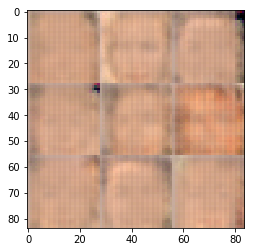

Epoch 1/1... Step 1110... Discriminator Loss: 1.0370... Generator Loss: 1.3842
Epoch 1/1... Step 1120... Discriminator Loss: 1.2539... Generator Loss: 0.8533
Epoch 1/1... Step 1130... Discriminator Loss: 1.1600... Generator Loss: 1.2971
Epoch 1/1... Step 1140... Discriminator Loss: 1.3986... Generator Loss: 2.3967
Epoch 1/1... Step 1150... Discriminator Loss: 0.5267... Generator Loss: 2.0313
Epoch 1/1... Step 1160... Discriminator Loss: 0.8478... Generator Loss: 1.0876
Epoch 1/1... Step 1170... Discriminator Loss: 1.5635... Generator Loss: 1.8750
Epoch 1/1... Step 1180... Discriminator Loss: 1.3917... Generator Loss: 0.8996
Epoch 1/1... Step 1190... Discriminator Loss: 1.3897... Generator Loss: 0.6763
Epoch 1/1... Step 1200... Discriminator Loss: 1.3375... Generator Loss: 0.8440
Sample Outputs....


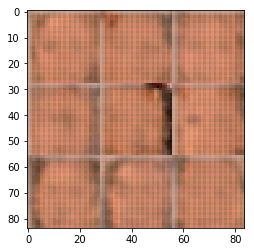

Epoch 1/1... Step 1210... Discriminator Loss: 1.3175... Generator Loss: 0.8770
Epoch 1/1... Step 1220... Discriminator Loss: 1.3199... Generator Loss: 1.0586
Epoch 1/1... Step 1230... Discriminator Loss: 1.3169... Generator Loss: 0.8479
Epoch 1/1... Step 1240... Discriminator Loss: 1.2812... Generator Loss: 0.9828
Epoch 1/1... Step 1250... Discriminator Loss: 1.2994... Generator Loss: 0.8798
Epoch 1/1... Step 1260... Discriminator Loss: 1.3333... Generator Loss: 0.8619
Epoch 1/1... Step 1270... Discriminator Loss: 1.3311... Generator Loss: 0.7557
Epoch 1/1... Step 1280... Discriminator Loss: 1.2877... Generator Loss: 0.8490
Epoch 1/1... Step 1290... Discriminator Loss: 1.2701... Generator Loss: 0.7873
Epoch 1/1... Step 1300... Discriminator Loss: 1.3210... Generator Loss: 1.0318
Sample Outputs....


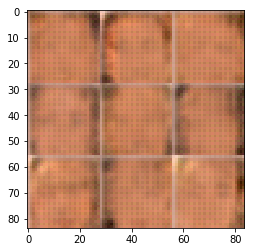

Epoch 1/1... Step 1310... Discriminator Loss: 1.3353... Generator Loss: 0.9640
Epoch 1/1... Step 1320... Discriminator Loss: 1.3483... Generator Loss: 0.9025
Epoch 1/1... Step 1330... Discriminator Loss: 1.3314... Generator Loss: 0.9781
Epoch 1/1... Step 1340... Discriminator Loss: 1.3050... Generator Loss: 0.8839
Epoch 1/1... Step 1350... Discriminator Loss: 1.3750... Generator Loss: 0.8315
Epoch 1/1... Step 1360... Discriminator Loss: 1.3061... Generator Loss: 0.9303
Epoch 1/1... Step 1370... Discriminator Loss: 1.3103... Generator Loss: 0.7879
Epoch 1/1... Step 1380... Discriminator Loss: 1.2865... Generator Loss: 0.8884
Epoch 1/1... Step 1390... Discriminator Loss: 1.2902... Generator Loss: 0.8196
Epoch 1/1... Step 1400... Discriminator Loss: 1.3419... Generator Loss: 0.8379
Sample Outputs....


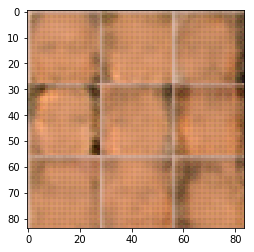

Epoch 1/1... Step 1410... Discriminator Loss: 1.3068... Generator Loss: 0.9563
Epoch 1/1... Step 1420... Discriminator Loss: 1.2887... Generator Loss: 0.9010
Epoch 1/1... Step 1430... Discriminator Loss: 1.2838... Generator Loss: 0.8690
Epoch 1/1... Step 1440... Discriminator Loss: 1.3432... Generator Loss: 0.8095
Epoch 1/1... Step 1450... Discriminator Loss: 1.3676... Generator Loss: 0.8393
Epoch 1/1... Step 1460... Discriminator Loss: 1.2674... Generator Loss: 0.9684
Epoch 1/1... Step 1470... Discriminator Loss: 1.3433... Generator Loss: 0.8104
Epoch 1/1... Step 1480... Discriminator Loss: 1.3296... Generator Loss: 0.8701
Epoch 1/1... Step 1490... Discriminator Loss: 1.3289... Generator Loss: 0.9528
Epoch 1/1... Step 1500... Discriminator Loss: 1.3533... Generator Loss: 0.7752
Sample Outputs....


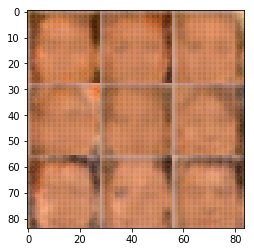

Epoch 1/1... Step 1510... Discriminator Loss: 1.2879... Generator Loss: 0.8648
Epoch 1/1... Step 1520... Discriminator Loss: 1.2963... Generator Loss: 0.9667
Epoch 1/1... Step 1530... Discriminator Loss: 1.3317... Generator Loss: 0.8016
Epoch 1/1... Step 1540... Discriminator Loss: 1.3160... Generator Loss: 0.8117
Epoch 1/1... Step 1550... Discriminator Loss: 1.3053... Generator Loss: 0.9147
Epoch 1/1... Step 1560... Discriminator Loss: 1.3555... Generator Loss: 1.0022
Epoch 1/1... Step 1570... Discriminator Loss: 1.3237... Generator Loss: 0.9331
Epoch 1/1... Step 1580... Discriminator Loss: 1.3245... Generator Loss: 0.7450
Epoch 1/1... Step 1590... Discriminator Loss: 1.3145... Generator Loss: 1.0097
Epoch 1/1... Step 1600... Discriminator Loss: 1.3192... Generator Loss: 0.8330
Sample Outputs....


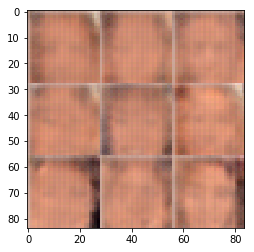

Epoch 1/1... Step 1610... Discriminator Loss: 1.2833... Generator Loss: 0.7921
Epoch 1/1... Step 1620... Discriminator Loss: 1.3256... Generator Loss: 0.7574
Epoch 1/1... Step 1630... Discriminator Loss: 1.3523... Generator Loss: 0.8435
Epoch 1/1... Step 1640... Discriminator Loss: 1.3052... Generator Loss: 0.8059
Epoch 1/1... Step 1650... Discriminator Loss: 1.3145... Generator Loss: 0.8444
Epoch 1/1... Step 1660... Discriminator Loss: 1.3164... Generator Loss: 0.8305
Epoch 1/1... Step 1670... Discriminator Loss: 1.3097... Generator Loss: 0.9143
Epoch 1/1... Step 1680... Discriminator Loss: 1.3439... Generator Loss: 0.8047
Epoch 1/1... Step 1690... Discriminator Loss: 1.3062... Generator Loss: 0.9941
Epoch 1/1... Step 1700... Discriminator Loss: 1.3458... Generator Loss: 0.9242
Sample Outputs....


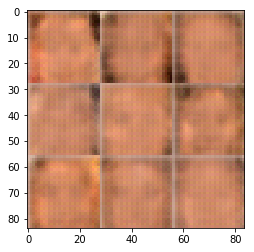

Epoch 1/1... Step 1710... Discriminator Loss: 1.2868... Generator Loss: 0.7151
Epoch 1/1... Step 1720... Discriminator Loss: 1.2859... Generator Loss: 1.0165
Epoch 1/1... Step 1730... Discriminator Loss: 1.3267... Generator Loss: 0.9866
Epoch 1/1... Step 1740... Discriminator Loss: 1.3077... Generator Loss: 0.8714
Epoch 1/1... Step 1750... Discriminator Loss: 1.3396... Generator Loss: 0.8235
Epoch 1/1... Step 1760... Discriminator Loss: 1.3395... Generator Loss: 0.7353
Epoch 1/1... Step 1770... Discriminator Loss: 1.3201... Generator Loss: 0.9245
Epoch 1/1... Step 1780... Discriminator Loss: 1.3280... Generator Loss: 0.8136
Epoch 1/1... Step 1790... Discriminator Loss: 1.3427... Generator Loss: 0.8445
Epoch 1/1... Step 1800... Discriminator Loss: 1.3449... Generator Loss: 0.8180
Sample Outputs....


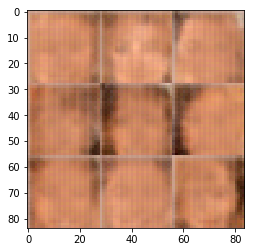

Epoch 1/1... Step 1810... Discriminator Loss: 1.3524... Generator Loss: 0.8489


KeyboardInterrupt: 

In [42]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.